In [1]:
import pandas as pd
import scipy

from sklearn.metrics import f1_score

In [128]:
df = pd.read_parquet('train_dataset_hackaton2023_train.gzip')

In [78]:
df_test = pd.read_parquet('test_dataset_hackaton2023_test.gzip')

In [79]:
df = df_test

In [129]:
df['startdatetime'] = pd.to_datetime(df['startdatetime'])

In [130]:
df = df.sort_values(by=['customer_id', 'startdatetime'])

In [131]:
df['timedifference'] = df.groupby('customer_id')['startdatetime'].diff()

In [132]:
df['order_diff'] = df.groupby('customer_id')['timedifference'].transform('mean')

In [133]:
wc = df.copy()

In [134]:
wc = wc.drop(['group_name', 'timedifference'], axis=1)

In [135]:
# Feature: Frequency
# wc['frequency'] = wc.groupby('customer_id')['dish_name'].transform('sum')

# Feature: Monetary (Total Revenue)
wc['monetary'] = wc.groupby('customer_id')['revenue'].transform('sum')

# Feature: Day of Week
# wc['day_of_week'] = pd.to_datetime(wc['startdatetime']).dt.day_name()

# Feature: Number of Unique Items
# wc['num_unique_items'] = wc.groupby('customer_id')['dish_name'].transform('nunique')

# Feature: Avg. Revenue per Order
# wc['avg_revenue_per_order'] = wc['monetary'] / wc['frequency']

In [136]:
def moda(series):
    return series.mode()[0] if not series.mode().empty else None

In [137]:
# Feature: Own Area Size
# Assuming 'ownareaall_sqm' is directly relevant to customer behavior

# Feature: Format Name
# Assuming 'format_name' is directly relevant to customer behavior

# Feature: Time since Last Visit
# df['time_since_last_visit'] = df.groupby('customer_id')['startdatetime'].diff().dt.days.fillna(0)

# Lag Features
# You might want to create lag features based on certain columns to capture trends

# Aggregated Statistics
wc['mean_revenue'] = wc.groupby('customer_id')['revenue'].transform('mean')
wc['median_revenue'] = wc.groupby('customer_id')['revenue'].transform('median')
wc['most_frequency_place'] = wc.groupby('customer_id')['format_name'].transform(moda)
# Drop unnecessary columns
wc = wc.drop(['startdatetime', 'dish_name'], axis=1)

In [141]:
after_groupby = wc

In [196]:
wc['avg_place_sqm'] = wc.groupby(['customer_id', 'most_frequency_place'])['ownareaall_sqm'].transform('mean')

In [197]:
wc = wc.groupby(['customer_id',
        'monetary', 'mean_revenue', 'median_revenue',
                 'buy_post',
                 'order_diff', 'most_frequency_place', 'avg_place_sqm']).agg({
     'revenue':['min', 'max', 'mean'],
     'ownareaall_sqm':['min', 'max', 'mean'],
     'date_diff_post': ['mean']})

In [195]:
wc = after_groupby

In [198]:
wc = wc.reset_index()

In [199]:
wc['date_diff_post'] = wc['date_diff_post'].fillna(61)

In [200]:
wc

customer_id monetary mean_revenue median_revenue buy_post  \
                                                                   
0            29891  5087.35   149.627941        147.480        1   
1            30477  5675.60    93.042623         59.990        1   
2            31426  9393.59   109.227791         39.995        1   
3            44491   514.90    51.490000         23.995        1   
4            44939  1664.83    66.593200         43.970        1   
...            ...      ...          ...            ...      ...   
499995    46624509   935.90    85.081818         79.990        0   
499996    46625265  1199.87    92.297692         70.000        0   
499997    46639170  1089.92    99.083636        119.990        1   
499998    46654016  1219.93   203.321667        159.990        1   
499999    46661804   834.93    55.662000         70.030        0   

                      order_diff  \
                                   
0      1 days 18:07:01.848484848   
1      0 days 20:47:27.933333333   
2      0 days 14:10:27.576470588   
3      3 days 02:14:35.444444444   
4      0 days 15:26:51.833333333   
...                          ...   
499995    0 days 02:55:57.600000   
499996 0 days 00:01:48.583333333   
499997    0 days 00:20:28.300000   
499998    0 days 01:12:22.800000   
499999 0 days 00:01:02.142857142   

                                 most_frequency_place avg_place_sqm revenue  \
                                                                        min   
0                    Отдельно стоящий с внешней зоной    439.029412    1.00   
1                   Отдельно стоящий без внешней зоны    320.000000    0.39   
2                                 Фудкорт без туалета    153.000000    1.00   
3       Отдельно стоящий без внешней зоны без туалета    128.884000   19.99   
4                                 Фудкорт без туалета    171.474400    1.00   
...                                               ...           ...     ...   
499995                            Фудкорт без туалета    112.530000    1.00   
499996                             Фудкорт с туалетом    120.000000   49.99   
499997                            Фудкорт без туалета     80.200000    1.00   
499998               Отдельно стоящий с внешней зоной    270.000000  129.98   
499999                             Фудкорт с туалетом    300.000000    7.99   

                           ownareaall_sqm                     date_diff_post  
           max        mean            min     max        mean           mean  
0       439.98  149.627941         300.00  463.00  439.029412            9.0  
1       399.99   93.042623         320.00  320.00  320.000000           10.0  
2       854.99  109.227791         153.00  153.00  153.000000            4.0  
3       229.99   51.490000          88.42  139.00  128.884000           42.0  
4       267.97   66.593200         129.27  280.00  171.474400            9.0  
...        ...         ...            ...     ...         ...            ...  
499995  189.99   85.081818         112.53  112.53  112.530000           61.0  
499996  169.98   92.297692         120.00  120.00  120.000000           61.0  
499997  179.99   99.083636          80.20   80.20   80.200000           10.0  
499998  429.99  203.321667         270.00  270.00  270.000000           15.0  
499999  100.00   55.662000         300.00  300.00  300.000000           61.0  

[500000 rows x 15 columns]

In [201]:
buy_cost_1 = wc[wc['buy_post'] == 1]
buy_cost_0 = wc[wc['buy_post'] == 0]
print(len(buy_cost_0))

# Sample 5,000 rows from each class
buy_cost_1_sample = buy_cost_1.sample(n=100000, random_state=42)
buy_cost_0_sample = buy_cost_0.sample(n=100000, random_state=42)

# Concatenate the two samples to create a balanced dataset
balanced_dataset = pd.concat([buy_cost_1_sample, buy_cost_0_sample])

# Shuffle the rows of the new dataset
balanced_dataset = balanced_dataset.sample(frac=1, random_state=42).reset_index(drop=True)

140905


In [94]:
balanced_dataset = wc

In [202]:
balanced_dataset = pd.concat([balanced_dataset.drop(columns=['most_frequency_place']), pd.get_dummies(balanced_dataset['most_frequency_place'])], axis=1)

In [ ]:
%pip install pycaret

In [154]:
# from pycaret.classification import *
from pycaret.regression import *

In [203]:
balanced_dataset.columns = ['_'.join(col).rstrip('_') for col in balanced_dataset.columns.values]

In [204]:
balanced_dataset

,customer_id,monetary,mean_revenue,median_revenue,buy_post,order_diff,avg_place_sqm,revenue_min,revenue_max,revenue_mean,...,date_diff_post_mean,Н_е_ _з_а_п_о_л_н_е_н_о,О_т_д_е_л_ь_н_о_ _с_т_о_я_щ_и_й,О_т_д_е_л_ь_н_о_ _с_т_о_я_щ_и_й_ _б_е_з_ _в_н_е_ш_н_е_й_ _з_о_н_ы,О_т_д_е_л_ь_н_о_ _с_т_о_я_щ_и_й_ _б_е_з_ _в_н_е_ш_н_е_й_ _з_о_н_ы_ _б_е_з_ _т_у_а_л_е_т_а,О_т_д_е_л_ь_н_о_ _с_т_о_я_щ_и_й_ _б_е_з_ _т_у_а_л_е_т_а,О_т_д_е_л_ь_н_о_ _с_т_о_я_щ_и_й_ _с_ _в_н_е_ш_н_._з_о_н_о_й_ _б_е_з_ _т_у_а_л_е_т_а,О_т_д_е_л_ь_н_о_ _с_т_о_я_щ_и_й_ _с_ _в_н_е_ш_н_е_й_ _з_о_н_о_й,Ф_у_д_к_о_р_т_ _б_е_з_ _т_у_а_л_е_т_а,Ф_у_д_к_о_р_т_ _с_ _т_у_а_л_е_т_о_м
0,9896778,2892.75,160.708333,129.990,0,2 days 02:16:20.117647058,110.400000,2.00,329.95,160.708333,...,61.0,0,0,0,0,0,0,0,1,0
1,34612520,7756.53,180.384419,129.990,1,0 days 17:03:31.428571428,102.302326,1.00,899.97,180.384419,...,2.0,0,0,0,0,0,0,0,1,0
2,11149715,1869.85,64.477586,50.000,0,1 days 02:37:56.178571428,290.000000,4.99,199.99,64.477586,...,61.0,0,0,0,0,0,0,1,0,0
3,22672330,901.94,75.161667,75.010,1,1 days 13:05:53.545454545,306.358333,10.00,199.99,75.161667,...,19.0,0,0,1,0,0,0,0,0,0
4,34410102,1084.89,120.543333,99.990,1,3 days 11:47:54.500000,280.000000,74.99,169.99,120.543333,...,14.0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,18939510,1170.95,195.158333,134.990,0,2 days 23:26:46.600000,96.000000,1.00,399.99,195.158333,...,61.0,0,0,0,0,0,0,0,1,0
199996,12312386,2035.88,127.242500,89.985,0,1 days 19:42:09,279.946875,1.00,499.99,127.242500,...,61.0,0,1,0,0,0,0,0,0,0
199997,27735541,3322.81,195.459412,129.990,0,2 days 02:49:51.812500,214.400000,44.99,799.98,195.459412,...,61.0,0,0,1,0,0,0,0,0,0
199998,13942928,3147.80,112.421429,67.495,0,0 days 09:03:59.074074074,288.425000,1.00,389.97,112.421429,...,61.0,0,0,0,0,0,0,1,0,0


In [205]:
balanced_dataset['order_diff'] = balanced_dataset['order_diff'].dt.total_seconds().astype('float32')

In [206]:
s = setup(balanced_dataset, target='date_diff_post_mean',
          #   ordinal_features = {'Количество_комнат' : ['студия', '1', '2','3','4','5']},
          imputation_type=None,
          # numeric_imputation='median',
          normalize=True,
          #           date_features=['Дата'],
#           text_features=['dish_name'],
          ignore_features=['buy_post'],
          session_id=123)

,Description,Value
0,Session id,123
1,Target,date_diff_post_mean
2,Target type,Regression
3,Original data shape,"(200000, 23)"
4,Transformed data shape,"(200000, 22)"
5,Transformed train set shape,"(140000, 22)"
6,Transformed test set shape,"(60000, 22)"
7,Ignore features,1
8,Numeric features,21
9,Preprocess,True


In [ ]:
best = compare_models(include = ['lr', 'rf', 'lightgbm', 'dummy', 'xgboost', 'catboost'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.6582,0.7202,0.6379,0.6649,0.6511,0.3163,0.3166,0.4290
catboost,CatBoost Classifier,0.6582,0.7201,0.6415,0.6637,0.6524,0.3165,0.3166,14.8490
xgboost,Extreme Gradient Boosting,0.6535,0.7145,0.6411,0.6575,0.6492,0.3071,0.3072,2.3140
rf,Random Forest Classifier,0.6452,0.7030,0.6127,0.6553,0.6333,0.2904,0.2910,2.2040
lr,Logistic Regression,0.6350,0.6887,0.5832,0.6506,0.6150,0.2700,0.2715,0.3990
dummy,Dummy Classifier,0.5000,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1740


Processing:   0%|          | 0/29 [00:00<?, ?it/s]

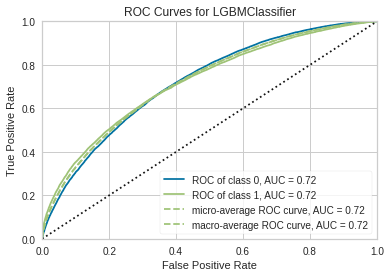

In [ ]:
plot_model(best, plot = 'auc')

In [207]:
lgb_r = create_model('lightgbm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,15.6747,341.7508,18.4865,0.2580,0.7110,1.1096
1,15.8883,347.8353,18.6503,0.2418,0.7071,1.0986
2,15.8391,347.0032,18.6280,0.2431,0.7163,1.1318
3,15.8608,347.8277,18.6501,0.2390,0.7114,1.1206
4,16.0307,357.2780,18.9018,0.2208,0.7229,1.1775
5,15.7927,343.9679,18.5464,0.2398,0.7052,1.1161
6,15.9998,355.4768,18.8541,0.2275,0.7247,1.1705
7,15.8062,346.3002,18.6091,0.2438,0.7152,1.1523
8,16.0202,354.9222,18.8394,0.2250,0.7205,1.1530


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [187]:
plot_model(lgb_r, plot = 'feature')

ImportError: ignored

In [104]:
df_test = balanced_dataset

In [105]:
df_test

,customer_id,monetary,mean_revenue,median_revenue,order_diff,avg_place_sqm,revenue_min,revenue_max,revenue_mean,ownareaall_sqm_min,...,ownareaall_sqm_mean,Н_е_ _з_а_п_о_л_н_е_н_о,О_т_д_е_л_ь_н_о_ _с_т_о_я_щ_и_й,О_т_д_е_л_ь_н_о_ _с_т_о_я_щ_и_й_ _б_е_з_ _в_н_е_ш_н_е_й_ _з_о_н_ы,О_т_д_е_л_ь_н_о_ _с_т_о_я_щ_и_й_ _б_е_з_ _в_н_е_ш_н_е_й_ _з_о_н_ы_ _б_е_з_ _т_у_а_л_е_т_а,О_т_д_е_л_ь_н_о_ _с_т_о_я_щ_и_й_ _б_е_з_ _т_у_а_л_е_т_а,О_т_д_е_л_ь_н_о_ _с_т_о_я_щ_и_й_ _с_ _в_н_е_ш_н_._з_о_н_о_й_ _б_е_з_ _т_у_а_л_е_т_а,О_т_д_е_л_ь_н_о_ _с_т_о_я_щ_и_й_ _с_ _в_н_е_ш_н_е_й_ _з_о_н_о_й,Ф_у_д_к_о_р_т_ _б_е_з_ _т_у_а_л_е_т_а,Ф_у_д_к_о_р_т_ _с_ _т_у_а_л_е_т_о_м
0,52341,2255.77,80.563214,92.995,102623.781250,338.900000,1.00,139.99,80.563214,338.9,...,338.900000,0,0,0,0,0,0,1,0,0
1,69175,3872.76,79.035918,75.010,62843.500000,254.985714,1.00,239.99,79.035918,227.3,...,254.985714,0,0,0,0,0,0,1,0,0
2,73427,7881.45,123.147656,90.000,80646.398438,179.842969,1.00,399.99,123.147656,100.0,...,179.842969,0,1,0,0,0,0,0,0,0
3,134577,1491.88,124.323333,109.990,46070.636719,207.600000,44.98,200.00,124.323333,207.6,...,207.600000,0,0,0,0,0,0,0,1,0
4,156357,1676.89,128.991538,109.990,310060.656250,127.032308,9.99,309.99,128.991538,124.0,...,127.032308,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112329,46540272,1324.90,132.490000,129.990,776.000000,81.000000,49.99,299.99,132.490000,81.0,...,81.000000,0,0,0,0,0,0,0,1,0
112330,46569275,1131.94,94.328333,87.480,15593.818359,236.350000,1.00,299.99,94.328333,89.8,...,236.350000,0,1,0,0,0,0,0,0,0
112331,46601088,579.95,72.493750,72.490,13389.142578,106.900000,10.00,124.99,72.493750,106.9,...,106.900000,0,0,0,0,0,0,0,1,0
112332,46632765,739.95,123.325000,119.990,18952.800781,225.000000,70.00,209.99,123.325000,225.0,...,225.000000,1,0,0,0,0,0,0,0,0


In [102]:
predictions = predict_model(lgb, data = df_test)

In [208]:
predictions_r = predict_model(lgb_r, data = df_test)

In [140]:
predictions[['customer_id', 'prediction_label']]

,customer_id,prediction_label
0,52341,1
1,69175,1
2,73427,1
3,134577,0
4,156357,1
...,...,...
112329,46540272,0
112330,46569275,0
112331,46601088,0
112332,46632765,0


In [164]:
predictions_r['prediction_label']

0         37.524482
1         41.348707
2         11.439464
3         75.414752
4         55.528360
            ...    
112329    81.642629
112330    78.991769
112331    80.140660
112332    80.203766
112333    79.979983
Name: prediction_label, Length: 112334, dtype: float64

In [209]:
submins = pd.concat([predictions[['customer_id', 'prediction_label']].rename(columns={'prediction_label': 'label'}), predictions_r['prediction_label']], axis=1)

In [210]:
submins

,customer_id,label,prediction_label
0,52341,1,30.671110
1,69175,1,31.821399
2,73427,1,12.204554
3,134577,0,54.275087
4,156357,1,41.635887
...,...,...,...
112329,46540272,0,56.830540
112330,46569275,0,54.087053
112331,46601088,0,56.235429
112332,46632765,0,54.344803


In [211]:
submins = submins.rename(columns={'label': 'buy_post', 'prediction_label': 'date_diff_post'})

In [212]:
submins = submins[['customer_id', 'date_diff_post', 'buy_post']]

In [213]:
submins

,customer_id,date_diff_post,buy_post
0,52341,30.671110,1
1,69175,31.821399,1
2,73427,12.204554,1
3,134577,54.275087,0
4,156357,41.635887,1
...,...,...,...
112329,46540272,56.830540,0
112330,46569275,54.087053,0
112331,46601088,56.235429,0
112332,46632765,54.344803,0


In [214]:
submins.to_csv('submission.csv', index=False, sep=';')